# Fundamentals of Data Analysis Assignment
## Autumn 2021

---
<br>

## Part 2 - CAO points

![CAO_logo](./Images/cao.png)
---

<br>

# A comparison of CAO points in 2019, 2020, and 2021

The brief was to analyse the CAO points for the years 2019, 2020, and 2021. The main tasks were to download the data from the CAO website, clean it, then analyse the data using pandas and to use visualisations to help better explain this analysis.

<br>

---

### Downloading the data

---

The data can be found at the following links which we save as variables to be used later.

In [1]:
url2021 = 'http://www2.cao.ie/points/l8.php'
url2020 = 'http://www2.cao.ie/points/CAOPointsCharts2020.xlsx'
url2019 = 'http://www2.cao.ie/points/lvl8_19.pdf'

A quick glance at the file extensions tells us we are dealing with three different file types so scraping the data is going to involve a few different methods.
To begin we import all the necessary libraries for the analysis and visualisations. These are shortened as per convention and economy of space.

In [2]:
# basic data analysis
import pandas as pd

# numerical arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# Dates and times
import datetime as dt

# Regular expressions
import re

# HTTP requests
import requests as rq

# for downloading and saving excel file
import urllib.request as urlrq

# working with csv files
import csv

# for pdf files
import tabula

We're going to use a timestamp to name the different updates of each downloaded and saved file. We use the `datetime` library for the current date and time which is then converted into a string using the `strftime` method. `%Y%m%d_%H%M%S` specifies the format we want the date/time in.

In [3]:
# get the current date and time
now = dt.datetime.now()

# format as a string
nowstr = now.strftime('%Y%m%d_%H%M%S')

<br>

---

## 2021 Points

---

The url - http://www2.cao.ie/points/l8.php - returns a php page with text and some internal hyperlinks. For analysis we need to download the text, extract only the information we need, and then convert it to a csv file. The first part of code below uses the `requests` library to fetch the data. A path is created using the stringified datetime preceded by the folder `data` and 'CAO2021'. This timestamp will serve a dual purpose as the data from 2021 is still being updated (at time of writing).

In [4]:
# fetch the cao url
resp = rq.get(url2021)

# Create a filepath for the original data using the datetime
path2021 = 'data/CAO2021_' + nowstr + '.html'

# confirm it's working (if we get a '200' response message)
resp

<Response [200]>

We then save the original file with the following code. 

In [5]:
# save the original html file
with open(path2021, 'w') as f:
    f.write(resp.text)

During the lectures it was discovered that some characters weren't being displayed properly. The issues lay with the fadas in the Irish language words, plus a stray 'em' hyphen. The server stated that the page should be decoded with **iso-8859-1** but this didn't allow for these particular characters. We changed the decoding to **cp1252** which solved the issue.

In [6]:
# the server uses the wrong encoding, fix it
original_encoding = resp.encoding

# change to cp1252
resp.encoding = 'cp1252'

<br>

#### Using regular expressions to isolate the data we want

On inspection the file contains a lot of information we don't need for the analysis such as headings, links, college names, etc., so the next challenge was to isolate only what was needed, i.e. 1) course code 2) course name 3) points.
The following code uses a **regular expression** to identify only the lines that match the expression.
- `([A-Z]{2}[0-9]{3})` = represents course code - i.e. CW078
- followed by 2 spaces
- `(.*)` represents an amount of text. The dot `.` serves as a wildcard and the `*` means zero or more of.

In [7]:
# compile the regular expression for matching lines
re_course = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')

We create a new path for saving the extracted data as a csv file.

In [8]:
# path for csv file
path2021b = 'data/CAO2021_csv_' + nowstr + '.csv'

We then loop through these lines and save then to a csv file to be also stored in the `data` folder. 

In [9]:
# keep track of courses
no_lines = 0

with open(path2021b, 'w') as f:
    # write a header row
    f.write(','.join(["Course_Code", "Course_Title", "PointsR1_2021", "PointsR2_2021"]) + '\n')
    
    # loop through lines of response
    for line in resp.iter_lines():
        
        # decode to cp1252
        dline = line.decode('cp1252')
        
        # match only the lines we want, i.e. those representing courses
        if re_course.fullmatch(dline):
            
            # add to line counter
            no_lines = no_lines + 1
            
            # course code (first 5 characters)
            course_code = dline[:5]
            
            # course_title
            course_title = dline[7:57].strip()
            
            # round 1 points
            course_points = re.split(' +', dline[60:])
            
            if len(course_points) != 2:
                course_points = course_points[:2]
                
            # split the line on 2 spaces or more
            linesplit = (course_code, course_title, course_points[0], course_points[1])
            
            # join the fields using a comma
            f.write(','.join(linesplit) + '\n')

Just to confirm we have every line we need, we print out the total number of lines and then try to verify that online. 

In [10]:
# prints the total number of lines    
print(f"Total number of lines is {no_lines}.")

Total number of lines is 949.


**N.B.** It was verified on 8/11 against the original data and we're good!

We open the new csv file with the `pandas` package to inspect.

In [11]:
# open the csv file and save to variable df2021
df2021 = pd.read_csv(path2021b, encoding='cp1252') 

# have a look at the first 10 rows
df2021.head(10)

,Course_Code,Course_Title,PointsR1_2021,PointsR2_2021
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN
5,AL811,Civil Engineering,NaN,NaN
6,AL820,Mechanical and Polymer Engineering,327,NaN
7,AL830,General Nursing,451*,444
8,AL832,Mental Health Nursing,440*,431
9,AL835,Pharmacology,356,NaN


We can see straight away a few potential issues! A lot of NaN values and some asterisks beside numbers. We use the `.info()` method to get an overview of the data.

In [12]:
df2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Course_Code    949 non-null    object
 1   Course_Title   949 non-null    object
 2   PointsR1_2021  928 non-null    object
 3   PointsR2_2021  258 non-null    object
dtypes: object(4)
memory usage: 29.8+ KB


We have no null values which is good but all of the points are of datatype object. We need to change that to numeric values so we can carry out analysis. 

We'll deal with the astericks, etc. in the points fields first. This solution is based on - https://pretagteam.com/question/remove-characters-from-pandas-column. By looking through the dataset I've identified all of the things I want to remove and replace them with blank space.

In [13]:
# replace unwanted characters
df2021 = df2021.replace('#', '', regex = True)
df2021 = df2021.replace('AQA', '', regex = True)
df2021 = df2021.replace('\*', '', regex = True)
df2021 = df2021.replace('\+matric', '', regex = True)
df2021 = df2021.replace('\+mat', '', regex = True)
df2021 = df2021.replace('e\)', '', regex = True)

# have a look
df2021.head()

,Course_Code,Course_Title,PointsR1_2021,PointsR2_2021
0,AL801,Software Design for Virtual Reality and Gaming,300,NaN
1,AL802,Software Design in Artificial Intelligence for...,313,NaN
2,AL803,Software Design for Mobile Apps and Connected ...,350,NaN
3,AL805,Computer Engineering for Network Infrastructure,321,NaN
4,AL810,Quantity Surveying,328,NaN


We'll use `pd.to_numeric()` to change the data type of the points fields to float.

In [14]:
# changing datatype
df2021['PointsR1_2021'] = pd.to_numeric(df2021['PointsR1_2021'])
df2021['PointsR2_2021'] = pd.to_numeric(df2021['PointsR2_2021'])

# have a look
df2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Course_Code    949 non-null    object 
 1   Course_Title   949 non-null    object 
 2   PointsR1_2021  923 non-null    float64
 3   PointsR2_2021  255 non-null    float64
dtypes: float64(2), object(2)
memory usage: 29.8+ KB


We now use the `.describe()` function to carry out initial analysis of the data.

In [15]:
# initial analysis of data
df2021.describe()

,PointsR1_2021,PointsR2_2021
count,923.000000,255.000000
mean,407.666306,414.749020
std,128.706224,141.693386
min,57.000000,60.000000
25%,303.000000,293.500000
50%,391.000000,424.000000
75%,499.000000,521.500000
max,1028.000000,904.000000


The main issue I can see here is that we have 923 values for Round 1 points but only 255 for round 2. It's going to be quite difficult to carry out any analysis with previous years with that situation. I think we need to create a third column containing the lower of the 2 values, as I guess this will be closer to the final points requirement. We create variables for each of the points columns and then define a function to return the smaller of each. By using the `.combine` method, we create a new column.

In [16]:
# creating variables for each column
df1 = df2021['PointsR1_2021']
df2 = df2021['PointsR2_2021']

# function to return smaller of each column
take_smaller = lambda s1, s2: s1 if s1 < s2 else s2

# create the new column
finalPoints2021 = df2.combine(df1, take_smaller)

# have a look
finalPoints2021

0      300.0
1      313.0
2      350.0
3      321.0
4      328.0
       ...  
944    270.0
945    262.0
946    230.0
947    266.0
948    261.0
Length: 949, dtype: float64

We add the new column to the dataframe and have a look.

In [17]:
# add new column to dataframe
df2021['finalPoints2021'] = finalPoints2021

# have a look
df2021.head()

,Course_Code,Course_Title,PointsR1_2021,PointsR2_2021,finalPoints2021
0,AL801,Software Design for Virtual Reality and Gaming,300.0,NaN,300.0
1,AL802,Software Design in Artificial Intelligence for...,313.0,NaN,313.0
2,AL803,Software Design for Mobile Apps and Connected ...,350.0,NaN,350.0
3,AL805,Computer Engineering for Network Infrastructure,321.0,NaN,321.0
4,AL810,Quantity Surveying,328.0,NaN,328.0


<br>

--- 

## 2020 Points

---

The 2020 data is already in an excel spreadsheet so a different approach is needed. We first save the original data and name it again using the timestamp created above.

In [18]:
# create a new path
path2020 = 'data/CAO2020_' + nowstr + '.html'

# Read and store content of excel file from a URL 
urlrq.urlretrieve(url2020, path2020)

('data/CAO2020_20220102_173138.html',
 <http.client.HTTPMessage at 0x7fe2847b4700>)

We read it in again using `pandas` skipping the first 10 rows which on inspection contained stuff we didn't need.

In [19]:
# skip the first 10 rows
df2020 = pd.read_excel (url2020, skiprows=10)

# have a look
df2020.head()

,CATEGORY (i.e.ISCED description),COURSE TITLE,COURSE CODE2,R1 POINTS,R1 Random *,R2 POINTS,R2 Random*,EOS,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that we have a lot more data than the 2021 version plus different headers. So straight away I'd like to rename the matching headers in anticipation of comparison further down the line.

In [20]:
# change the necessary headers - Course_Code,Course_Title,PointsR1,PointsR2
df2020 = df2020.rename(columns={'COURSE TITLE': 'Course_Title', 'COURSE CODE2': 'Course_Code', 
                                'R1 POINTS': 'PointsR1_2020', 'R2 POINTS': 'PointsR2_2020', 'EOS': 'EOS_2020'})

# have a look
df2020.head()

,CATEGORY (i.e.ISCED description),Course_Title,Course_Code,PointsR1_2020,R1 Random *,PointsR2_2020,R2 Random*,EOS_2020,EOS Random *,EOS Mid-point,...,avp,v,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
0,Business and administration,International Business,AC120,209,NaN,NaN,NaN,209,NaN,280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humanities (except languages),Liberal Arts,AC137,252,NaN,NaN,NaN,252,NaN,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arts,"First Year Art & Design (Common Entry,portfolio)",AD101,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arts,Graphic Design and Moving Image Design (portfo...,AD102,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arts,Textile & Surface Design and Jewellery & Objec...,AD103,#+matric,NaN,NaN,NaN,#+matric,NaN,#+matric,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We notice that the dataframe contains information for level 6 and 7 courses which we don't want. I'm first of all going to get rid of all of the extraneous columnns and then look at filtering out all of the non-level 8 courses. We just want the Course_Code, Course_Title, PointsR1_2020, PointsR2_2020, LEVEL. We will also take EOS, as this is the points total for the final accepted candidate. Something roughly comparable to our newly created `finalPoints2021` column in the 2021 file.  

**EOS** is the 
>*".. FINAL CUT-OFF points, in other words, the points score achieved by the last applicant being offered a place on that course in 2008. The second column gives the MID figure, that is, the points score of the applicant midway between the highest and the lowest applicant being offered a place."*
https://www.independent.ie/life/family/learning/understanding-your-cao-course-guide-26505318.html

In [21]:
# extract the relevent columns and reorder
df2020 = df2020[['Course_Code','Course_Title','PointsR1_2020','PointsR2_2020', 'EOS_2020', 'LEVEL']]

# have a look
df2020.head()

,Course_Code,Course_Title,PointsR1_2020,PointsR2_2020,EOS_2020,LEVEL
0,AC120,International Business,209,NaN,209,8
1,AC137,Liberal Arts,252,NaN,252,8
2,AD101,"First Year Art & Design (Common Entry,portfolio)",#+matric,NaN,#+matric,8
3,AD102,Graphic Design and Moving Image Design (portfo...,#+matric,NaN,#+matric,8
4,AD103,Textile & Surface Design and Jewellery & Objec...,#+matric,NaN,#+matric,8


In [22]:
# filter rows where level equals 8
df2020 = df2020.loc[df2020['LEVEL'] == 8]

We now drop the LEVEL column.

In [23]:
df2020.drop('LEVEL', axis=1, inplace=True)

Now to address the non-numeric values in the points column.

In [24]:
# replace non-numeric characters in points fields
df2020 = df2020.replace('#', '', regex = True)
df2020 = df2020.replace('AQA', '', regex = True)
df2020 = df2020.replace('\*', '', regex = True)
df2020 = df2020.replace('\+matric', '', regex = True)
df2020 = df2020.replace('\+mat', '', regex = True)
df2020 = df2020.replace('e\)', '', regex = True)
df2020.head()

,Course_Code,Course_Title,PointsR1_2020,PointsR2_2020,EOS_2020
0,AC120,International Business,209,NaN,209
1,AC137,Liberal Arts,252,NaN,252
2,AD101,"First Year Art & Design (Common Entry,portfolio)",,NaN,
3,AD102,Graphic Design and Moving Image Design (portfo...,,NaN,
4,AD103,Textile & Surface Design and Jewellery & Objec...,,NaN,


We'll use `.info()` again to take a look at the data.

In [25]:
# overview of data
df2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027 entries, 0 to 1463
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Course_Code    1027 non-null   object
 1   Course_Title   1027 non-null   object
 2   PointsR1_2020  1008 non-null   object
 3   PointsR2_2020  212 non-null    object
 4   EOS_2020       1014 non-null   object
dtypes: object(5)
memory usage: 48.1+ KB


Again we see we need to change the points values to numeric datatypes.

In [26]:
# change points from object to float
df2020['PointsR1_2020'] = pd.to_numeric(df2020['PointsR1_2020'])
df2020['PointsR2_2020'] = pd.to_numeric(df2020['PointsR2_2020'])
df2020['EOS_2020'] = pd.to_numeric(df2020['EOS_2020'])

We now try some initial analysis.

In [27]:
df2020.describe()

,PointsR1_2020,PointsR2_2020,EOS_2020
count,989.000000,209.000000,993.000000
mean,394.300303,394.521531,391.799597
std,126.135161,127.579578,128.446837
min,55.000000,184.000000,55.000000
25%,301.000000,282.000000,300.000000
50%,370.000000,402.000000,368.000000
75%,476.000000,498.000000,474.000000
max,1088.000000,768.000000,1088.000000


We save the updated dataframe to file.

In [28]:
# saving updated pandas dataframe as csv file
# creating path
path2020b = 'data/CAO2020_' + nowstr + '.csv'
# writing to csv
df2020.to_csv(path2020b)

<br>

---

## 2019 Points

---

The 2019 points are in PDF format! A bit of googling found the `tabula` library which seems to deal with PDFs quite easily.
Link to tabula - https://github.com/chezou/tabula-py. I installed it by running `pip install tabula-py`.

In [29]:
# access the pdf file using parameters in referenced link above
df = tabula.read_pdf(url2019, stream=True, pages="all")

# have a look
# df

Seems to work!  
Next, we convert it to a csv file and name it using the timestamp method again, and save it to the data folder.

In [30]:
# convert PDF into CSV file
tabula.convert_into(url2019, 'data/CAO2019_' + nowstr + '.csv', output_format="csv", pages='all')

We read it in again with `pandas`.

In [31]:
# reads in the csv file
df2019 = pd.read_csv("data/CAO2019_20220102_161053.csv")

# have a look
df2019.head(10)

,Course Code,INSTITUTION and COURSE,EOS,Mid
0,NaN,Athlone Institute of Technology,NaN,NaN
1,AL801,Software Design with Virtual Reality and Gaming,304,328
2,AL802,Software Design with Cloud Computing,301,306
3,AL803,Software Design with Mobile Apps and Connected...,309,337
4,AL805,Network Management and Cloud Infrastructure,329,442
5,AL810,Quantity Surveying,307,349
6,AL820,Mechanical and Polymer Engineering,300,358
7,AL830,General Nursing,410,429
8,AL832,Psychiatric Nursing,387,403
9,AL836,Nutrition and Health Science,352,383


A few issues here. Firstly we don't have any indiviual round 1 and 2 points - just EOS and a column named 'Mid'. Also the univeristy names are taking up rows! We'll deal with that first (solution based on https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).  
On inspection of the data we see that every course entry has a course code and an EOS/Mid entry. The institution names contain NaNs for these fields, so we use the `.dropna()` method to get rid of these.

In [32]:
# deletes rows where there are blanks
df2019 = df2019.dropna(subset=['Course Code'])

# have a look
df2019.head()

,Course Code,INSTITUTION and COURSE,EOS,Mid
1,AL801,Software Design with Virtual Reality and Gaming,304,328
2,AL802,Software Design with Cloud Computing,301,306
3,AL803,Software Design with Mobile Apps and Connected...,309,337
4,AL805,Network Management and Cloud Infrastructure,329,442
5,AL810,Quantity Surveying,307,349


We also need to rename the headers to match the other years files. As we don't have round 1 and 2 points we'll just take 'EOS' (Mid doesn't really seem relevent to us and we've nothing comparable in 2021)

In [33]:
# rename columns for Course_code and Course_title but leave the others
df2019 = df2019.rename(columns={'INSTITUTION and COURSE': 'Course_Title', 
                                'Course Code': 'Course_Code', 'EOS': 'EOS_2019'})

# have a look
df2019.head()

,Course_Code,Course_Title,EOS_2019,Mid
1,AL801,Software Design with Virtual Reality and Gaming,304,328
2,AL802,Software Design with Cloud Computing,301,306
3,AL803,Software Design with Mobile Apps and Connected...,309,337
4,AL805,Network Management and Cloud Infrastructure,329,442
5,AL810,Quantity Surveying,307,349


A quick overview of the data.

In [34]:
# overview
df2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 1 to 964
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Course_Code   930 non-null    object
 1   Course_Title  930 non-null    object
 2   EOS_2019      926 non-null    object
 3   Mid           915 non-null    object
dtypes: object(4)
memory usage: 36.3+ KB


Again we need to conver the points data from object to numeric.

In [35]:
# https://stackoverflow.com/questions/39173813/pandas-convert-dtype-object-to-int
df2019['EOS_2019'] = pd.to_numeric(df2019['EOS_2019'], errors='coerce')

And we'll do some initial analysis of the data.

In [36]:
df2019.describe()

,EOS_2019
count,791.000000
mean,351.364096
std,88.284545
min,168.000000
25%,285.500000
50%,330.000000
75%,410.000000
max,601.000000


We save the amended file using the same method as above.

In [37]:
# create a new path
path2019b = 'data/CAO2019_' + nowstr + '.csv'

# saving amended file to folder
df2019.to_csv(path2019b)

<br>

---

### Concat and join

---

Now we have the data in a useable form we start to do some work on it and prepare it for analysis. We begin by isolating the course code and course title from each year and creating new variables for each.

In [38]:
# create new variable
courses2021 = df2021[['Course_Code', 'Course_Title']]

# have a look
courses2021.head()

,Course_Code,Course_Title
0,AL801,Software Design for Virtual Reality and Gaming
1,AL802,Software Design in Artificial Intelligence for...
2,AL803,Software Design for Mobile Apps and Connected ...
3,AL805,Computer Engineering for Network Infrastructure
4,AL810,Quantity Surveying


In [39]:
# create new variable
courses2020 = df2020[['Course_Code', 'Course_Title']]

In [40]:
# create new variable
courses2019 = df2019[['Course_Code', 'Course_Title']]

We use `pandas.concat` to concatenate each of these variables to the one dataframe which we call `allCourses`.

In [41]:
# concatenate
allCourses = pd.concat([courses2021, courses2020, courses2019], ignore_index=True)

# have a look
# allCourses.head()

We sort the values into alphabetical order based on course code.

In [42]:
# sort values
allCourses = allCourses.sort_values('Course_Code')

We show all duplicated rows using the `pandas.duplicated` method.

In [43]:
allCourses[allCourses.duplicated(subset=['Course_Code'])]

,Course_Code,Course_Title
2144,AC120,International Business
949,AC120,International Business
2145,AC137,Liberal Arts
950,AC137,Liberal Arts
2390,AD101,First Year Art & Design (Common Entry)
...,...,...
944,WD211,Creative Computing
945,WD212,Recreation and Sport Management
1974,WD212,Recreation and Sport Management
946,WD230,Mechanical and Manufacturing Engineering


We drop all the duplicated rows.

In [44]:
# drop duplicates based on code
# inplace changes original dataframe - default is opposite
allCourses.drop_duplicates(subset=['Course_Code'], inplace=True, ignore_index=True)
# allCourses

---

### Join to the points

---

We set the index to 'Course_code'.

In [45]:
# set index
allCourses.set_index('Course_Code', inplace=True)

In [46]:
df2021_FINAL = df2021[['Course_Code', 'finalPoints2021']]
# df2021_FINAL

In [47]:
df2021_FINAL.set_index('Course_Code', inplace=True)

In [48]:
allCourses = allCourses.join(df2021_FINAL)
allCourses.head()

,Course_Title,finalPoints2021
Course_Code,,
AC120,International Business,294.0
AC137,Liberal Arts,270.0
AD101,First Year Art and Design (Common Entry portfo...,554.0
AD102,Graphic Design and Moving Image Design (portfo...,538.0
AD103,Textile and Surface Design and Jewellery and O...,505.0


In [49]:
df2020_EOS = df2020[['Course_Code', 'EOS_2020']]

In [50]:
df2020_EOS.set_index('Course_Code', inplace=True)
# df2020_r1

In [51]:
allCourses = allCourses.join(df2020_EOS)
allCourses.head()

,Course_Title,finalPoints2021,EOS_2020
Course_Code,,,
AC120,International Business,294.0,209.0
AC137,Liberal Arts,270.0,252.0
AD101,First Year Art and Design (Common Entry portfo...,554.0,NaN
AD102,Graphic Design and Moving Image Design (portfo...,538.0,NaN
AD103,Textile and Surface Design and Jewellery and O...,505.0,NaN


In [52]:
df2019_EOS = df2019[['Course_Code', 'EOS_2019']]
df2019_EOS.head()

,Course_Code,EOS_2019
1,AL801,304.0
2,AL802,301.0
3,AL803,309.0
4,AL805,329.0
5,AL810,307.0


In [53]:
df2019_EOS.set_index('Course_Code', inplace=True)
df2019_EOS.head()

,EOS_2019
Course_Code,
AL801,304.0
AL802,301.0
AL803,309.0
AL805,329.0
AL810,307.0


In [54]:
allCourses = allCourses.join(df2019_EOS)
allCourses

,Course_Title,finalPoints2021,EOS_2020,EOS_2019
Course_Code,,,,
AC120,International Business,294.0,209.0,234.0
AC137,Liberal Arts,270.0,252.0,252.0
AD101,First Year Art and Design (Common Entry portfo...,554.0,NaN,NaN
AD102,Graphic Design and Moving Image Design (portfo...,538.0,NaN,NaN
AD103,Textile and Surface Design and Jewellery and O...,505.0,NaN,NaN
...,...,...,...,...
WD211,Creative Computing,270.0,271.0,275.0
WD212,Recreation and Sport Management,262.0,270.0,274.0
WD230,Mechanical and Manufacturing Engineering,230.0,253.0,273.0


Reorder again

In [55]:
allCourses = allCourses.sort_values('Course_Code')

In [56]:
allCourses.head()

,Course_Title,finalPoints2021,EOS_2020,EOS_2019
Course_Code,,,,
AC120,International Business,294.0,209.0,234.0
AC137,Liberal Arts,270.0,252.0,252.0
AD101,First Year Art and Design (Common Entry portfo...,554.0,NaN,NaN
AD102,Graphic Design and Moving Image Design (portfo...,538.0,NaN,NaN
AD103,Textile and Surface Design and Jewellery and O...,505.0,NaN,NaN


We save this version as a csv to file using the same method as above.

In [57]:
# create a new path to save file to
pathAllCourses = 'data/CAOAllYears_' + nowstr + '.csv'

# saving amended file to folder
allCourses.to_csv(pathAllCourses)

<br>

---

### Some analysis

---

We do some basic analysis of each year with the `describe()` function.

In [58]:
allCourses['finalPoints2021'].describe()

count     923.000000
mean      404.913326
std       128.748376
min        57.000000
25%       301.500000
50%       391.000000
75%       497.500000
max      1028.000000
Name: finalPoints2021, dtype: float64

In [59]:
allCourses['EOS_2020'].describe()

count     993.000000
mean      391.799597
std       128.446837
min        55.000000
25%       300.000000
50%       368.000000
75%       474.000000
max      1088.000000
Name: EOS_2020, dtype: float64

In [60]:
allCourses['EOS_2019'].describe()

count    791.000000
mean     351.364096
std       88.284545
min      168.000000
25%      285.500000
50%      330.000000
75%      410.000000
max      601.000000
Name: EOS_2019, dtype: float64

We visualise that with a barchart.

In [61]:
# create variables for mean points
a = allCourses['EOS_2019'].mean()
b = allCourses['EOS_2020'].mean()
c = allCourses['finalPoints2021'].mean()

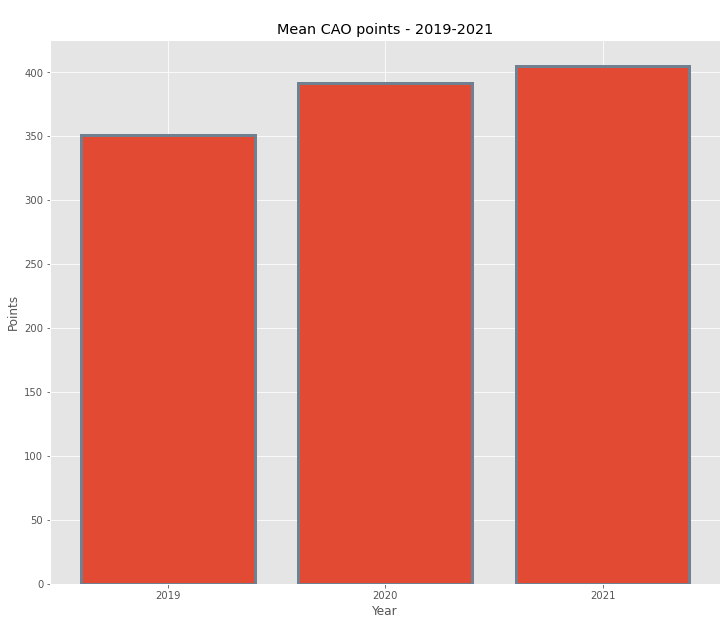

In [62]:
# set figure size and style
plt.rcParams["figure.figsize"] = (12,10)
plt.style.use('ggplot')

# definte data for x and y
x = ('2019', '2020', '2021')
y = [a, b, c]
 
# titles
plt.title("\nMean CAO points - 2019-2021")
plt.xlabel("Year")
plt.ylabel("Points")

# Create bar chart
plt.bar(x, y, edgecolor='slategrey', linewidth=3);

I want to find the mean points per institution and by year
I want to find the highest and points each year

In [63]:
column1 = allCourses['EOS_2019']
column2 = allCourses['EOS_2020']
column3 = allCourses['finalPoints2021']
max_value1 = column1.max()
max_value1 = int(max_value1)
max_index1 = column1.idxmax()
max_value2 = column2.max()
max_value2 = int(max_value2)
max_index2 = column2.idxmax()
max_value3 = column3.max()
max_value3 = int(max_value3)
max_index3 = column3.idxmax()

In [64]:
x = allCourses.loc[column1.idxmax(), 'Course_Title']
y = allCourses.loc[column1.idxmax(), 'Course_Title']
z = allCourses.loc[column1.idxmax(), 'Course_Title']

In [65]:
print(f"The highest points in 2019 was {max_value1} for course {max_index1} - {x}")
print(f"The highest points in 2020 was {max_value2} for course {max_index2} - {y}")
print(f"The highest points in 2021 was {max_value3} for course {max_index3} - {z}")

The highest points in 2019 was 601 for course DN670 - Economics and Finance
The highest points in 2020 was 1088 for course CR125 - Economics and Finance
The highest points in 2021 was 1028 for course CR125 - Economics and Finance


In [66]:
allCourses['Course_Title']

Course_Code
AC120                               International Business
AC137                                         Liberal Arts
AD101    First Year Art and Design (Common Entry portfo...
AD102    Graphic Design and Moving Image Design (portfo...
AD103    Textile and Surface Design and Jewellery and O...
                               ...                        
WD211                                   Creative Computing
WD212                      Recreation and Sport Management
WD230             Mechanical and Manufacturing Engineering
WD231                   Early Childhood Care and Education
WD232                         Business Information Systems
Name: Course_Title, Length: 1214, dtype: object

I'm going to try and insert the institution names. The first 2 letters of the course code references the institution so I'm going to create a new column with a copy of the index. 

In [67]:
allCourses['index1'] = allCourses.index
allCourses

,Course_Title,finalPoints2021,EOS_2020,EOS_2019,index1
Course_Code,,,,,
AC120,International Business,294.0,209.0,234.0,AC120
AC137,Liberal Arts,270.0,252.0,252.0,AC137
AD101,First Year Art and Design (Common Entry portfo...,554.0,NaN,NaN,AD101
AD102,Graphic Design and Moving Image Design (portfo...,538.0,NaN,NaN,AD102
AD103,Textile and Surface Design and Jewellery and O...,505.0,NaN,NaN,AD103
...,...,...,...,...,...
WD211,Creative Computing,270.0,271.0,275.0,WD211
WD212,Recreation and Sport Management,262.0,270.0,274.0,WD212
WD230,Mechanical and Manufacturing Engineering,230.0,253.0,273.0,WD230


Now I'm going to try and isolate the first 2 letters of each code.

In [68]:
allCourses['index1'] = allCourses['index1'].str[:2]
allCourses.head()

,Course_Title,finalPoints2021,EOS_2020,EOS_2019,index1
Course_Code,,,,,
AC120,International Business,294.0,209.0,234.0,AC
AC137,Liberal Arts,270.0,252.0,252.0,AC
AD101,First Year Art and Design (Common Entry portfo...,554.0,NaN,NaN,AD
AD102,Graphic Design and Moving Image Design (portfo...,538.0,NaN,NaN,AD
AD103,Textile and Surface Design and Jewellery and O...,505.0,NaN,NaN,AD


OK I have to create a big list of institutions now I guess!

In [69]:
# creats a new column based on 2 letters of course code
allCourses.loc[allCourses['index1'] == 'AL', 'Institution'] = "Athlone Institute of Technology" 
allCourses.loc[allCourses['index1'] == 'AC', 'Institution'] = "American College Dublin" 
allCourses.loc[allCourses['index1'] == 'CW', 'Institution'] = "Institute of Technology Carlow" 
allCourses.loc[allCourses['index1'] == 'PC', 'Institution'] = "Carlow College, St. Patrick`s" 
allCourses.loc[allCourses['index1'] == 'CR', 'Institution'] = "Cork Institute of Technology" 
allCourses.loc[allCourses['index1'] == 'BY', 'Institution'] = "IBAT College Dublin" 
allCourses.loc[allCourses['index1'] == 'CM', 'Institution'] = "Marino Institute of Education" 
allCourses.loc[allCourses['index1'] == 'CT', 'Institution'] = "CCT College Dublin" 
allCourses.loc[allCourses['index1'] == 'DB', 'Institution'] = "Dublin Business School"
allCourses.loc[allCourses['index1'] == 'DC', 'Institution'] = "Dublin City University" 
allCourses.loc[allCourses['index1'] == 'DK', 'Institution'] = "Dundalk Institute of Technology" 
allCourses.loc[allCourses['index1'] == 'DL', 'Institution'] = "Dun Laoghaire Institute of Art, Design & Technology" 
allCourses.loc[allCourses['index1'] == 'GA', 'Institution'] = "Galway-Mayo Institute of Technology" 
allCourses.loc[allCourses['index1'] == 'GC', 'Institution'] = "Griffith College Dublin, Cork & Limerick" 
allCourses.loc[allCourses['index1'] == 'ID', 'Institution'] = "ICD Business School, Dublin" 
allCourses.loc[allCourses['index1'] == 'SG', 'Institution'] = "Institute of Technology Sligo" 
allCourses.loc[allCourses['index1'] == 'TU', 'Institution'] = "TU Dublin"
allCourses.loc[allCourses['index1'] == 'TL', 'Institution'] = "Institute of Technology Tralee" 
allCourses.loc[allCourses['index1'] == 'CI', 'Institution'] = "Irish College of Humanities & Applied Sciences" 
allCourses.loc[allCourses['index1'] == 'LY', 'Institution'] = "Letterkenny Institute of Technology" 
allCourses.loc[allCourses['index1'] == 'LC', 'Institution'] = "Limerick Institute of Technology" 
allCourses.loc[allCourses['index1'] == 'MI', 'Institution'] = "Mary Immaculate College of Education" 
allCourses.loc[allCourses['index1'] == 'AD', 'Institution'] = "National College of Art and Design" 
allCourses.loc[allCourses['index1'] == 'NC', 'Institution'] = "National College of Ireland(NCI)" 
allCourses.loc[allCourses['index1'] == 'GY', 'Institution'] = "National University Of Ireland, Galway" 
allCourses.loc[allCourses['index1'] == 'MH', 'Institution'] = "Maynooth University" 
allCourses.loc[allCourses['index1'] == 'MU', 'Institution'] = "Pontifical University, Maynooth" 
allCourses.loc[allCourses['index1'] == 'RC', 'Institution'] = "RCSI University of Medicine & Health Sciences" 
allCourses.loc[allCourses['index1'] == 'AS', 'Institution'] = "St. Angela`s College" 
allCourses.loc[allCourses['index1'] == 'TR', 'Institution'] = "Trinity College Dublin" 
allCourses.loc[allCourses['index1'] == 'CK', 'Institution'] = "University College Cork(NUI)" 
allCourses.loc[allCourses['index1'] == 'DN', 'Institution'] = "University College Dublin(NUI)" 
allCourses.loc[allCourses['index1'] == 'LM', 'Institution'] = "University of Limerick" 
allCourses.loc[allCourses['index1'] == 'WD', 'Institution'] = "Waterford Institute of Technology"
allCourses.loc[allCourses['index1'] == 'BN', 'Institution'] = "Technological University Dublin Blanchardstown Campus"
allCourses.loc[allCourses['index1'] == 'DT', 'Institution'] = "Technological University Dublin City Campus"
allCourses.loc[allCourses['index1'] == 'DS', 'Institution'] = "Dorset College"
allCourses.loc[allCourses['index1'] == 'GB', 'Institution'] = "Galway Business School"
allCourses.loc[allCourses['index1'] == 'NM', 'Institution'] = "St Nicholas Montessori College Ireland"
allCourses.loc[allCourses['index1'] == 'TA', 'Institution'] = "Technological University Dublin Tallaght Campus"

# have a look
allCourses.head()

,Course_Title,finalPoints2021,EOS_2020,EOS_2019,index1,Institution
Course_Code,,,,,,
AC120,International Business,294.0,209.0,234.0,AC,American College Dublin
AC137,Liberal Arts,270.0,252.0,252.0,AC,American College Dublin
AD101,First Year Art and Design (Common Entry portfo...,554.0,NaN,NaN,AD,National College of Art and Design
AD102,Graphic Design and Moving Image Design (portfo...,538.0,NaN,NaN,AD,National College of Art and Design
AD103,Textile and Surface Design and Jewellery and O...,505.0,NaN,NaN,AD,National College of Art and Design


I'm going to delete index1 now, and save the result as a new csv file.

In [70]:
allCourses.drop('index1', axis=1, inplace=True)
allCourses.head()

,Course_Title,finalPoints2021,EOS_2020,EOS_2019,Institution
Course_Code,,,,,
AC120,International Business,294.0,209.0,234.0,American College Dublin
AC137,Liberal Arts,270.0,252.0,252.0,American College Dublin
AD101,First Year Art and Design (Common Entry portfo...,554.0,NaN,NaN,National College of Art and Design
AD102,Graphic Design and Moving Image Design (portfo...,538.0,NaN,NaN,National College of Art and Design
AD103,Textile and Surface Design and Jewellery and O...,505.0,NaN,NaN,National College of Art and Design


In [71]:
# create a new path to save file to
pathAllCoursesNew = 'data/CAOAllYearsB_' + nowstr + '.csv'

# saving amended file to folder
allCourses.to_csv(pathAllCoursesNew)

A quick glance through the new csv file shows that there are large gaps in the data. There are lots of courses that seem to have only have points for a single year. One reason for this I think is that some of the institution names have changed - e.g. TU Dublin seems to be an amalgamation of three other ITs (https://en.wikipedia.org/wiki/Technological_University_Dublin). Also, course names may have changed, orjust been discontinued. So, with all these gaps and inconsistencies, any analysis will be quite suspect! In the real world, a lot more research and data cleaning would be necessary but for the purposes of this project we'll carry on.  

In [72]:
a = allCourses['EOS_2019'].count()
b = allCourses['EOS_2020'].count()
c = allCourses['finalPoints2021'].count()

print(f"There were a total of {a} courses offered in 2019")
print(f"There were a total of {b} courses offered in 2020")
print(f"There were a total of {c} courses offered in 2021")

There were a total of 791 courses offered in 2019
There were a total of 993 courses offered in 2020
There were a total of 923 courses offered in 2021


Seems strange that there's such a range between each of the years! That certainly would warrant further exploration!

Next we're going to look at how many courses each institute ran. We use the `value_counts()` method to find how many entries per institution. The result will return the most courses the institution ran in any of the 3 years.

In [73]:
# value counts per institution
allCourses['Institution'].value_counts()

Trinity College Dublin                                   128
TU Dublin                                                120
Dublin City University                                    74
National University Of Ireland, Galway                    73
Technological University Dublin City Campus               69
University College Cork(NUI)                              67
Limerick Institute of Technology                          54
Galway-Mayo Institute of Technology                       53
Cork Institute of Technology                              47
University of Limerick                                    46
Institute of Technology Sligo                             43
University College Dublin(NUI)                            42
Waterford Institute of Technology                         39
Maynooth University                                       37
Institute of Technology Carlow                            35
Athlone Institute of Technology                           32
Dundalk Institute of Tec

We can plot that to get a better idea.

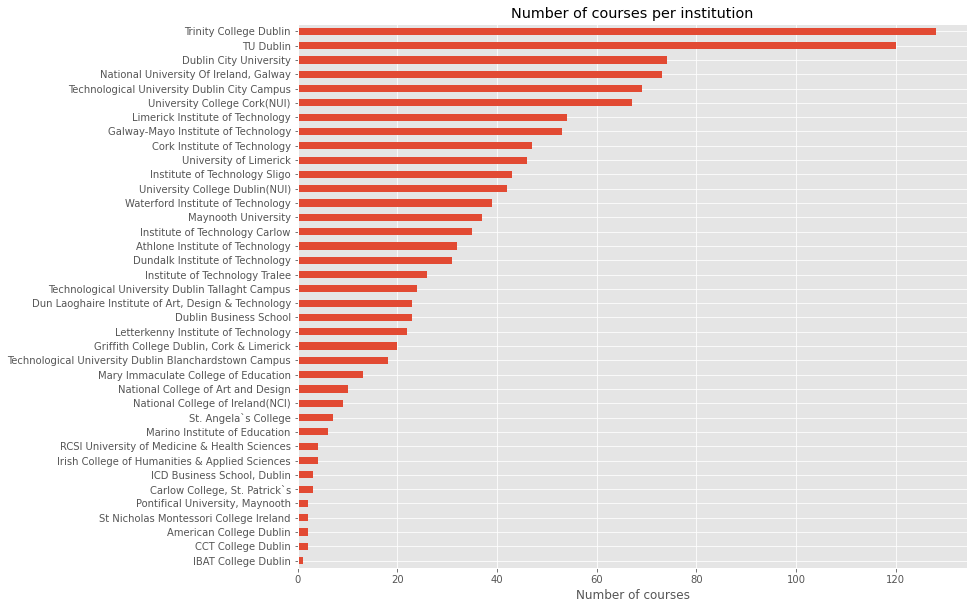

In [74]:
# set title
plt.title("Number of courses per institution")

# set x,y labels
plt.xlabel("Number of courses")

# plot value counts of courses
allCourses['Institution'].value_counts().sort_values().plot(kind='barh');

This gives us a good idea of the relative sizes of each of the institutions. We could do a separate one per year but I'm not sure much more we'd learn.  

We'll take a look at a few of the institutions in isolation. We'll look at Trinity first as it seems to be the biggest.

In [75]:
trinity = allCourses.loc[allCourses['Institution'] == 'Trinity College Dublin']
trinity.describe()

,finalPoints2021,EOS_2020,EOS_2019
count,54.000000,125.000000,36.000000
mean,532.851852,474.736000,468.888889
std,70.933508,84.598115,75.208198
min,377.000000,329.000000,337.000000
25%,486.250000,398.000000,415.500000
50%,546.000000,498.000000,485.500000
75%,577.750000,531.000000,520.750000
max,743.000000,734.000000,576.000000


First issue seems to be the count - we have a huge discrepancy between the number of courses offered each year! Something wrong there! Also there seems to be a big increase in the max points value in 2020 and 2021? Anyway we're going to focus on the average points and compare it to the other bigger institutions. So to finish I'm going to plot the average points score for the biggest 10 institutions over the last 3 years.

In [76]:
TU = allCourses.loc[allCourses['Institution'] == 'TU Dublin']
DCU = allCourses.loc[allCourses['Institution'] == 'Dublin City University']
NUIG = allCourses.loc[allCourses['Institution'] == 'National University Of Ireland, Galway']
TUD = allCourses.loc[allCourses['Institution'] == 'Technological University Dublin City Campus']
UCC = allCourses.loc[allCourses['Institution'] == 'University College Cork(NUI)']
LIT = allCourses.loc[allCourses['Institution'] == 'Limerick Institute of Technology']
GMIT = allCourses.loc[allCourses['Institution'] == 'Galway-Mayo Institute of Technology']
CIT = allCourses.loc[allCourses['Institution'] == 'Cork Institute of Technology']
UL = allCourses.loc[allCourses['Institution'] == 'University of Limerick']
ITS = allCourses.loc[allCourses['Institution'] == 'Institute of Technology Sligo']

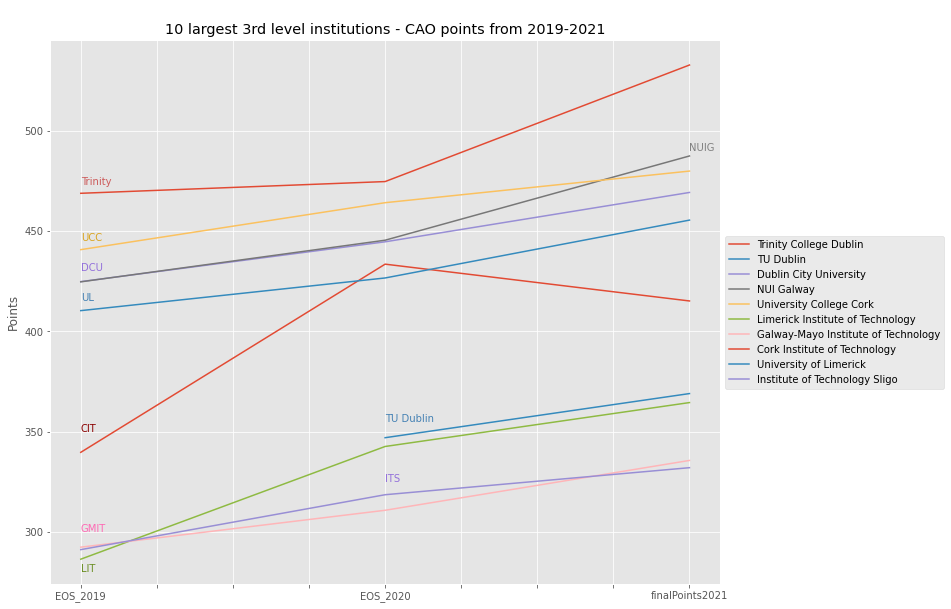

In [77]:
# add text to line
plt.text(0, 473,'Trinity', color='indianred')
# plot mean points for each year
trinity[['EOS_2019', 'EOS_2020', 'finalPoints2021']].mean().plot()

plt.text(1, 355,'TU Dublin', color='steelblue')
TU[['EOS_2019', 'EOS_2020', 'finalPoints2021']].mean().plot()

plt.text(0, 430,'DCU', color='mediumpurple')
DCU[['EOS_2019', 'EOS_2020', 'finalPoints2021']].mean().plot()

plt.text(2, 490,'NUIG', color='grey')
NUIG[['EOS_2019', 'EOS_2020', 'finalPoints2021']].mean().plot()

plt.text(0, 445,'UCC', color='goldenrod')
UCC[['EOS_2019', 'EOS_2020', 'finalPoints2021']].mean().plot()

plt.text(0, 280,'LIT', color='olivedrab')
LIT[['EOS_2019', 'EOS_2020', 'finalPoints2021']].mean().plot()

plt.text(0, 300,'GMIT', color='hotpink')
GMIT[['EOS_2019', 'EOS_2020', 'finalPoints2021']].mean().plot()

plt.text(0, 350,'CIT', color='darkred')
CIT[['EOS_2019', 'EOS_2020', 'finalPoints2021']].mean().plot()

plt.text(0, 415,'UL', color='steelblue')
UL[['EOS_2019', 'EOS_2020', 'finalPoints2021']].mean().plot()

plt.text(1, 325,'ITS', color='mediumpurple')
ITS[['EOS_2019', 'EOS_2020', 'finalPoints2021']].mean().plot()

# add legend
plt.legend(["Trinity College Dublin", "TU Dublin", "Dublin City University", "NUI Galway", 
          "University College Cork", "Limerick Institute of Technology", "Galway-Mayo Institute of Technology", "Cork Institute of Technology",
          "University of Limerick", "Institute of Technology Sligo"], loc='center left', bbox_to_anchor=(1, 0.5))

# add title
plt.title("\n10 largest 3rd level institutions - CAO points from 2019-2021")

# add y label
plt.ylabel("Points");

So we can see that Trinity is the top university each year. UCC has been pipped by NUIG in 2021! GMIT and Sligo IT are fighting it out for 9th and 10th place. All institutions points rose each year except CIT which took a big dip in 2021.

<br>

---

**N.B. The CAO website updated the 2021 points during the completion of this project and released an excel spreadsheet which can be found at this address - http://www2.cao.ie/points/CAOPointsCharts2021.xlsx. The format of this spreadsheet is similar to the 2020 version so would have aided this project considerably! In trying to work with the original text file though I feel we learnt more useful techniques. So while the newer version may produce slightly more accurate results than what I arrived at, I decided to keep the older version to demonstrate this learning.**

<br>

---

## References

---

CAO homepage - http://www.cao.ie/index.php

pandas.read_excel - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

Adding new column to existing DataFrame in Pandas - https://www.geeksforgeeks.org/adding-new-column-to-existing-dataframe-in-pandas/

pandas.DataFrame.combine - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.combine.html

Pandas plot value counts barplot in descending manner - https://stackoverflow.com/questions/49059956/pandas-plot-value-counts-barplot-in-descending-manner

Remove characters from pandas column - https://pretagteam.com/question/remove-characters-from-pandas-column

Tabula - https://github.com/chezou/tabula-py

pandas.DataFrame.dropna - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

Pandas convert dtype 'object' to int - https://stackoverflow.com/questions/39173813/pandas-convert-dtype-object-to-int

---

# THE END